In [1]:
from typing import List, Union, Dict
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr

import rdkit
import rdkit.Chem
import rdkit.Chem.AllChem as Chem
import rdkit.Chem.rdFingerprintGenerator as rdFP

try:
    import umap
except:
    !pip install umap-learn
    import umap
from rdkit import Chem

import matplotlib.pyplot as plt
import seaborn as sns

import deepchem as dc
import chemprop

from chemprop.models import MPN
from chemprop.args import TrainArgs
from chemprop.data import get_data_from_deepchem
from chemprop.features import BatchMolGraph
from chemprop.nn_utils import get_activation_function, initialize_weights

# set device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'DEVICE : {device}')

DEVICE : cuda:0


In [2]:
%load_ext autoreload
%autoreload 2

### Load some data from DeepChem

In [3]:
task, data, ids = dc.molnet.load_delaney(splitter=None)
df = data[0].to_dataframe()
df = df.rename(columns={'ids': 'smiles'})
print(df.shape)
df.head()

(1128, 1027)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1018,X1019,X1020,X1021,X1022,X1023,X1024,y,w,smiles
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.088088,1.0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.119254,1.0,Cc1occc1C(=O)Nc2ccccc2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.472487,1.0,CC(C)=CCCC(C)=CC(=O)
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.300105,1.0,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.820851,1.0,c1ccsc1


In [4]:
smiles = df['smiles'].tolist()
y      = df['y'].values.reshape(-1, 1)

In [5]:
# split into train/test target/context
smiles_context = smiles[:500]
smiles_target = smiles[500:]

y_context = y[:500]
y_target = y[500:]

### _TESTING_ Run the standalone MPN from chemprop

In [6]:
# get the data from deepchem
context_data = get_data_from_deepchem(smiles_array=smiles_context, targets_array=y_context)
target_data  = get_data_from_deepchem(smiles_array=smiles_target, targets_array=y_target)
context_data

/home/riley/Research_Local/chemprop/chemprop/data/utils.py:320: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  targets = [float(targets_array[i]) if targets_array[i] != '' else None]


In [9]:
# generate the batchgraph objects for context and target sets 
context_graph = context_data.batch_graph()
context_y     = context_data.targets()
target_graph  = target_data.batch_graph()
target_y      = context_data.targets()

In [10]:
context_graph

In [11]:
# define training args
args = TrainArgs()
args.mpn_shared = True
args.dataset_type = 'regression'
args.process_args()

In [12]:
# instantiate the MPN model
model_mpn = MPN(args)
model_mpn.to(device)

MPN(
  (encoder): ModuleList(
    (0): MPNEncoder(
      (dropout_layer): Dropout(p=0.0, inplace=False)
      (act_func): ReLU()
      (W_i): Linear(in_features=147, out_features=300, bias=False)
      (W_h): Linear(in_features=300, out_features=300, bias=False)
      (W_o): Linear(in_features=433, out_features=300, bias=True)
    )
  )
)

In [13]:
# get the embeddings for the context set (# samples, 300)
preds = model_mpn(context_graph)
preds_numpy = preds.cpu().data.numpy()

In [14]:
preds_numpy.shape

(500, 300)

In [15]:
# play around with the data loading
task, data, ids = dc.molnet.load_delaney(splitter=None)
X = data[0].X        # ECFP fingerprints
y = data[0].y        # targets
smiles = data[0].ids # smiles

print(X.shape, y.shape, len(smiles))

dataset = {'smiles': smiles, 'X': X, 'y': y}


(1128, 1024) (1128, 1) 1128


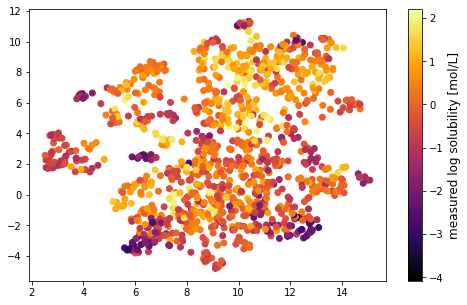

In [16]:
# put umap over data for visualization
fig = plt.figure(figsize=(8, 5))
y_umap = umap.UMAP(metric='cosine', min_dist=0.65).fit_transform(X)
plt.scatter(y_umap[:, 0], y_umap[:, 1], c=y.ravel(), cmap='inferno')
cbar = plt.colorbar().set_label('measured log solubility [mol/L]', fontsize=12)


plt.savefig('delany_umap.png', dpi=300)

In [17]:
# split into tasks --> evenly sized, for now

np.random.seed()
num_tasks = 15                  # ~ 75 mols per task
num_per_task = 75

indices = np.arange(X.shape[0])
np.random.shuffle(indices)

tasks = []

for task_ix in range(num_tasks):
    
    task_smiles = smiles[indices[:num_per_task]]
    task_X      = X[indices[:num_per_task], :]
    task_y      = y[indices[:num_per_task], :]
    
    tasks.append({'smiles':task_smiles.tolist(), 
                  'X':torch.from_numpy(task_X), 
                  'y':torch.from_numpy(task_y)}
            )

    indices = np.roll(indices, num_per_task)

In [18]:
# randomly split tasks into training and validation
NUM_TRAIN_TASKS = 12
NUM_VALID_TASKS = 3


train_tasks = tasks[:NUM_TRAIN_TASKS]
valid_tasks = tasks[NUM_TRAIN_TASKS:]

### Metrics class

In [19]:
class Metrics:
    
    @staticmethod
    def r2(true, pred):
        return r2_score(true, pred)
    @staticmethod
    def rmse(true, pred):
        return np.sqrt(mean_squared_error(true, pred))
    @staticmethod
    def mae(true, pred):
        return mean_absolute_error(true, pred)
    @staticmethod
    def pearson(true, pred):
        true, pred = np.squeeze(true), np.squeeze(pred)
        return pearsonr(true, pred)
    @staticmethod
    def spearman(true, pred):
        true, pred = np.squeeze(true), np.squeeze(pred)
        return spearmanr(true, pred)

    def compute_metrics(self, true, pred, kinds):
        metrics = {}
        for kind in kinds:
            try:
                fn = getattr(self, kind)
            except NameError as e:
                print(e)
            error = fn(true, pred)
            metrics[kind] = error
        return metrics

### _Testing_ Build the MPCNP model

#### Unique modules
* MPNN (used for representation learning in the encoder and decoder branch) --> directly from chemprop
* MLP (feedforward network used for the encoder and decoder) --> implemented here

#### Instances
* MPNN (rep learning) 
* MLP encoder
* MLP decoder

In [20]:
# MLP
class MLPEncoder(nn.Module):
    ''' Densely connected feed-forward MLP - encoder 
    '''
    def __init__(self,
                 params,
                 inp_size,
                 **kwargs
        ):
        super(MLPEncoder, self).__init__()
        self.params = params
        self.inp_size = inp_size
        
        num_layers = len(self.params['hidden_size'])+1
        
        layers = []
        for hidden_ix, hidden_size in enumerate(self.params['hidden_size']):
            if hidden_ix == 0:
                layers.append(nn.Linear(inp_size, hidden_size))
            else:
                layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            
        layers.append(nn.Linear(self.params['hidden_size'][-1], self.params['out_size']))
        #layers.append(self.params['out_act'])
        
        self.mlp = nn.Sequential(*layers)

        
        
    def forward(self, 
                mpn_rep_x,
                context_y,
            ) -> torch.FloatTensor:
        ''' forward pass of fully-connected MLP
        
        Args:
            mpn_rep_x : output of mpnn for context_x
            context_y : respective context_y values
        '''
        
        # concatenate the mpn_rep_x and context_y
        enc_input = torch.cat((mpn_rep_x, context_y), dim=-1) # [batch_size, n_context, inp_size]
        batch_size, filter_size = enc_input.shape[0], enc_input.shape[-1]                       
        enc_input = enc_input.view(-1, self.inp_size)             # [batch_size * n_context, inp_size]
        
        enc_out = self.mlp(enc_input.float())                         # [batch_size * n_context, hidden_size]
        
        enc_out = enc_out.view(batch_size, -1, self.params['out_size']) # [batch_size, n_context, hidden_size]
        
        rep     = torch.mean(enc_out, 1)                      # [batch_size, hidden_size]
        
        return rep

In [21]:
# MLP
class MLPDecoder(nn.Module):
    ''' Densely connected feed-forward MLP - encoder 
    '''
    def __init__(self,
                 params,
                 inp_size,
                 **kwargs
        ):
        super(MLPDecoder, self).__init__()
        self.params = params
        self.inp_size = inp_size
        
        num_layers = len(self.params['hidden_size'])+1
        
        layers = []
        for hidden_ix, hidden_size in enumerate(self.params['hidden_size']):
            if hidden_ix == 0:
                layers.append(nn.Linear(inp_size, hidden_size))
            else:
                layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            
        layers.append(nn.Linear(self.params['hidden_size'][-1], self.params['out_size']))
        #layers.append(self.params['out_act'])
        
        self.mlp = nn.Sequential(*layers)

        
        
    def forward(self, 
                mpn_rep_x, 
                enc_rep,
            ) -> torch.FloatTensor:
        ''' forward pass of fully-connected MLP
        
        Args:
            mpn_rep_x : output of mpnn for target_x
            enc_rep   : representation from encoder
        '''

        
        batch_size = mpn_rep_x.shape[0]
        
        enc_rep = torch.unsqueeze(enc_rep, dim=1).repeat(1, mpn_rep_x.shape[1], 1)  # inflate inputs
        
        # filter_size = enc_rep_size + mpn_rep_x_size
        dec_input = torch.cat((mpn_rep_x, enc_rep), dim=2)                  # [batch_size, n_target, filter_size]
        
        dec_input = dec_input.view(-1, self.inp_size)                       # [batch_size*n_target, filter_size]
        
        dec_out = self.mlp(dec_input.float())                               # [batch_size*n_target, 2*output_size]
        
        mu, log_sigma = torch.split(dec_out, 1, dim=1)
        
        # TODO:  last dim is hardcoded - fix this
        mu = mu.view(batch_size, -1, 1)                                     # [batch_size, n_target, output_size]
        
        sigma = 0.1 + 0.9 * nn.Softplus()(log_sigma)
        sigma = sigma.view(batch_size, -1, 1)
        
        dist = [MultivariateNormal(m, torch.diag_embed(s)) for m, s in zip(mu, sigma)]
        
        return mu, sigma, dist

In [22]:
# MPCNP model
class MPCNP():
    ''' Message-passing conditional neural process model
    '''
    DEF_ARGS = TrainArgs()
    DEF_ARGS.mpn_shared = True
    DEF_ARGS.dataset_type = 'regression'
    DEF_ARGS.process_args()
    
    DEF_ENCODER_PARAMS   = {'hidden_size': [100, 100],
                            'out_size': 50, 
                            'hidden_act': lambda y: nn.ReLU(y),
                    }
    DEF_DECODER_PARAMS   = {'hidden_size': [100, 100],
                            'out_size': 2, 
                            'hidden_act': nn.ReLU(),
                    }
 

    def __init__(self,
                 args: TrainArgs=None,               # MPNN args
                 encoder_params:Dict[str, any]=None,
                 decoder_params:Dict[str, any]=None,
                 use_mpnn:bool=True, 
                 learning_rate:float=1e-4,
                 batch_size:int=20, 
                 pred_int:int=25, 
                 epochs:int=8000, 
                 x_size:int=300,
                 y_size:int=1,
                 context_x_scaling:str='same',
                 context_y_scaling:str='same', 
                 target_x_scaling:str='same',
                 target_y_scaling:str='same', 
                 device:str='gpu',
                 **kwargs,
    ):
#        super(MPCNP, self).__init__()
        self.use_mpnn = use_mpnn
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.pred_int = pred_int
        self.epochs = 8000
        self.x_size = x_size           # this should be embedding size in this case
        self.y_size = y_size
        self.output_size = 2*self.y_size # mean + var for each y dim
        self.context_x_scaling = context_x_scaling
        self.context_y_scaling = context_y_scaling
        self.target_x_scaling = target_x_scaling
        self.target_y_scaling = target_y_scaling
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f'DEVICE : {self.device}')

        self.encoder_params = self._parse_params(
                                    encoder_params,
                                    self.DEF_ENCODER_PARAMS,
                            )
        self.decoder_params = self._parse_params(
                                    decoder_params, 
                                    self.DEF_DECODER_PARAMS,
                            )
        
        self._create_encoder()
        params_encoder = list(self.encoder.parameters())
        self._create_decoder()
        params_decoder = list(self.decoder.parameters())
        
        
        if self.use_mpnn:
            self.args = args or self.DEF_ARGS
            self._create_mpn()
            params_mpnn = list(self.mpn.parameters())
        else:
            params_mpnn = []
            
        
        self.optimizer = torch.optim.Adam(
                                    params_mpnn+
                                    params_encoder+
                                    params_decoder,
                                    lr=self.learning_rate,
                    )
        
        self.metrics = Metrics()
        
    
   
    def _parse_params(self, user_params, default_params):
        if not user_params:
            params = default_params
        
        elif type(user_params)==dict:
            params = {}
            for key, val in default_params.items():
                try:
                    params[key] = user_params[key] 
                except: 
                    params[key] = val
        else:
            print('@@\tUser hyperparams not understood, resorting to default... [WARNING] ')
            params = default_params
        return params
            
        
    def _create_mpn(self):
        self.mpn = MPN(self.args)
        self.mpn.to(self.device)
    
    def _create_encoder(self):
        self.encoder = MLPEncoder(self.encoder_params, self.x_size+self.y_size)
        self.encoder.to(self.device)
        
    def _create_decoder(self):
        self.decoder = MLPDecoder(self.decoder_params, self.encoder_params['out_size']+self.x_size)
        self.decoder.to(self.device)
        
    def loss_fn(self, dist, target_y):
        ''' negative log-likelihood
        '''
        log_probs = [d.log_prob(target_y[_, ...].float()) for _, d in enumerate(dist)]
        return -torch.mean(torch.cat(log_probs, dim=0))

        
    def train(self,
              train_tasks,
              valid_tasks, 
              
        ):
        ''' train the MPCNP
        
        Args: 
        
            train_tasks (list): list of training task data
            valid_tasks (list): list of validation task data
        '''
        
        train_losses = []
        valid_losses = []
        all_train_metrics = []
        all_valid_metrics = []
        
        num_train_tasks = len(train_tasks)
        num_valid_tasks = len(valid_tasks)
        
        for epoch in range(self.epochs):
            
            self.optimizer.zero_grad()
            
            task_ix = np.random.randint(num_train_tasks)
            train_task = train_tasks[task_ix]
                
            
            train_smiles = np.array(train_task['smiles'])
            train_x      = train_task['X']
            train_y      = train_task['y']
            
            
            num_target  = torch.randint(low=10, high=int(0.8*train_x.shape[0]), size=(1,))
            num_context = torch.randint(low=5, high=int(num_target), size=(1,))
            
            indices = [np.random.permutation(train_x.shape[0])[:num_target] for _ in range(self.batch_size)]
            indices_context = [indices[_][:num_context] for _ in range(self.batch_size)]
            
            train_target_x  = [train_x[indices[_], :] for _ in range(self.batch_size)]
            train_target_y  = [train_y[indices[_], :] for _ in range(self.batch_size)]
            
            train_target_smiles = [train_smiles[indices[_]] for _ in range(self.batch_size)]
            
            train_context_x = [train_x[indices_context[_], :] for _ in range(self.batch_size)]
            train_context_y = [train_y[indices_context[_], :] for _ in range(self.batch_size)]
            
            train_context_smiles = [train_smiles[indices_context[_]] for _ in range(self.batch_size)]
            
            if self.use_mpnn:                 
                # generate the chemprop data loader thing --> context
                context_hs = []
                for batch_ix, (batch_smiles, batch_y) in enumerate(zip(train_context_smiles, train_context_y)):
                    mol_dataset = get_data_from_deepchem(smiles_array=batch_smiles, targets_array=batch_y)
                    graph, y = mol_dataset.batch_graph(), mol_dataset.targets()
                    h = self.mpn(graph)
                    context_hs.append(h)
                train_context_x = torch.stack(context_hs).cuda()
                    
                # generate the target hs
                target_hs = []
                for batch_ix, (batch_smiles, batch_y) in enumerate(zip(train_target_smiles, train_target_y)):
                    mol_dataset = get_data_from_deepchem(smiles_array=batch_smiles, targets_array=batch_y)
                    graph, y = mol_dataset.batch_graph(), mol_dataset.targets()
                    h = self.mpn(graph)
                    target_hs.append(h)
                train_target_x = torch.stack(target_hs).cuda()
                
            else:
                train_target_x  = torch.stack(train_target_x).cuda()
                train_context_x = torch.stack(train_context_x).cuda()
                    
            # concatenate along a new dimension
            train_target_y  = torch.stack(train_target_y).cuda()
            train_context_y = torch.stack(train_context_y).cuda()
            
            # representation from deterministic encoder
            rep = self.encoder.forward(train_context_x, train_context_y)
            
            # run decoder
            mu, sigma, dist = self.decoder.forward(train_target_x, rep) 
            
            # compute loss
            loss = self.loss_fn(dist, train_target_y)
            
            # make predictions on the validation set
            if epoch % self.pred_int == 0:
                
                # MAKE PREDICTION ON TRAIN TASKS -----------------------------
                train_metrics = []
                for true, pred in zip(train_target_y, mu):
                    # compute metrics on train set
                    tms_batch  = self.metrics.compute_metrics(true.cpu().data.numpy(),
                                                              pred.cpu().data.numpy(),
                                                              ['r2', 'mae', 'rmse', 'pearson', 'spearman',]
                                                    )
                    train_metrics.append(tms_batch)
                
                train_r2  = np.mean([t['r2'] for t in train_metrics])
                train_mae = np.mean([t['mae'] for t in train_metrics]) 

        
                
                # MAKE PREDICTION ON VALIDATION TASKS -------------------------
                task_ix_valid = np.random.randint(num_valid_tasks)
                valid_task = valid_tasks[task_ix_valid]

                valid_smiles = np.array(valid_task['smiles'])
                valid_x = valid_task['X']
                valid_y = valid_task['y']


                num_target  = torch.randint(low=10, high=int(0.8*valid_x.shape[0]), size=(1,))
                num_context = torch.randint(low=5, high=int(num_target), size=(1,))

                indices = [np.random.permutation(valid_x.shape[0])[:num_target] for _ in range(self.batch_size)]
                indices_context = [indices[_][:num_context] for _ in range(self.batch_size)]

                valid_target_x  = [valid_x[indices[_], :] for _ in range(self.batch_size)]
                valid_target_y  = [valid_y[indices[_], :] for _ in range(self.batch_size)]
                
                valid_target_smiles = [valid_smiles[indices[_]] for _ in range(self.batch_size)]
                
                valid_context_x = [valid_x[indices_context[_], :] for _ in range(self.batch_size)]
                valid_context_y = [valid_y[indices_context[_], :] for _ in range(self.batch_size)]
                
                valid_context_smiles = [valid_smiles[indices_context[_]] for _ in range(self.batch_size)]
                
                
                if self.use_mpnn:                 
                    # generate the chemprop data loader thing --> context
                    context_hs = []
                    for batch_ix, (batch_smiles, batch_y) in enumerate(zip(valid_context_smiles, valid_context_y)):
                        mol_dataset = get_data_from_deepchem(smiles_array=batch_smiles, targets_array=batch_y)
                        graph, y = mol_dataset.batch_graph(), mol_dataset.targets()
                        h = self.mpn(graph)
                        context_hs.append(h)
                    valid_context_x = torch.stack(context_hs).cuda()

                    # generate the target hs
                    target_hs = []
                    for batch_ix, (batch_smiles, batch_y) in enumerate(zip(valid_target_smiles, valid_target_y)):
                        mol_dataset = get_data_from_deepchem(smiles_array=batch_smiles, targets_array=batch_y)
                        graph, y = mol_dataset.batch_graph(), mol_dataset.targets()
                        h = self.mpn(graph)
                        target_hs.append(h)
                    valid_target_x = torch.stack(target_hs).cuda()
                
                else:
                    valid_target_x  = torch.stack(valid_target_x).cuda()
                    valid_context_x = torch.stack(valid_context_x).cuda()

                # concatenate along a new dimension
                valid_target_y  = torch.stack(valid_target_y).cuda()
                valid_context_y = torch.stack(valid_context_y).cuda()
                
                 # representation from deterministic encoder
                rep = self.encoder.forward(valid_context_x, valid_context_y)

                # run decoder
                mu, sigma, dist = self.decoder.forward(valid_target_x, rep) 

                # compute loss
                valid_loss = self.loss_fn(dist, valid_target_y)
                
                # MAKE PREDICTION ON TRAIN TASKS -----------------------------
                valid_metrics = []
                for true, pred in zip(valid_target_y, mu):
                    # compute metrics on train set
                    vms_batch  = self.metrics.compute_metrics(true.cpu().data.numpy(),
                                                              pred.cpu().data.numpy(),
                                                              ['r2', 'mae', 'rmse', 'pearson', 'spearman',]
                                                    )
                    valid_metrics.append(vms_batch)
                
                valid_r2  = np.mean([t['r2'] for t in valid_metrics])
                valid_mae = np.mean([t['mae'] for t in valid_metrics]) 
               
                print(f'@@\tEPOCH : {epoch}\tTRAIN LOSS : {loss:.3f}\tVALID LOSS : {valid_loss:.3f}\tTRAIN R2 : {train_r2:.3f}\tVALID R2 : {valid_r2:.3f}')
        
                
            loss.backward()
            self.optimizer.step()

        return None
        
        
        
    def predict(self,
                context_x, 
                context_y,
                target_x,
                num_samples:int=1,
            ): 
        ''' Forward pass of the MPCNP
        '''
    
        # return pred_mean, pred_std, pred_dist
        return None
    

### Test out the model

In [23]:
mpcnp = MPCNP()

DEVICE : cuda:0


In [24]:
mpcnp.train(train_tasks, valid_tasks)

@@	EPOCH : 0	TRAIN LOSS : 1.520	VALID LOSS : 1.284	TRAIN R2 : -0.022	VALID R2 : -0.330
@@	EPOCH : 25	TRAIN LOSS : 1.571	VALID LOSS : 1.397	TRAIN R2 : -0.099	VALID R2 : -0.006
@@	EPOCH : 50	TRAIN LOSS : 1.477	VALID LOSS : 1.384	TRAIN R2 : 0.113	VALID R2 : 0.043
@@	EPOCH : 75	TRAIN LOSS : 1.385	VALID LOSS : 1.194	TRAIN R2 : 0.215	VALID R2 : -0.109
@@	EPOCH : 100	TRAIN LOSS : 1.162	VALID LOSS : 1.142	TRAIN R2 : 0.464	VALID R2 : 0.063
@@	EPOCH : 125	TRAIN LOSS : 1.098	VALID LOSS : 1.042	TRAIN R2 : 0.466	VALID R2 : 0.479
@@	EPOCH : 150	TRAIN LOSS : 1.200	VALID LOSS : 0.976	TRAIN R2 : 0.319	VALID R2 : 0.566
@@	EPOCH : 175	TRAIN LOSS : 0.915	VALID LOSS : 0.948	TRAIN R2 : 0.611	VALID R2 : 0.544
@@	EPOCH : 200	TRAIN LOSS : 0.963	VALID LOSS : 0.894	TRAIN R2 : 0.694	VALID R2 : 0.721
@@	EPOCH : 225	TRAIN LOSS : 1.075	VALID LOSS : 0.985	TRAIN R2 : 0.310	VALID R2 : 0.555
@@	EPOCH : 250	TRAIN LOSS : 0.877	VALID LOSS : 0.841	TRAIN R2 : 0.626	VALID R2 : 0.754
@@	EPOCH : 275	TRAIN LOSS : 0.686	VALID LOS

KeyboardInterrupt: 